In [60]:
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from PIL import Image

import os
import matplotlib.pyplot as plt

rs = 242130893
batch_size = 1024


torch.manual_seed(rs)
np.random.seed(rs)


base_dir = '/kaggle/input/'


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.device(device)

print(f"Available Device: {device}")

Available Device: cuda:0


In [61]:
from torch.utils.data import ConcatDataset

tensor_transform = transforms.Compose([
            transforms.Resize((32,40),antialias=True),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1),
        ])

train_transforms = transforms.Compose([
        transforms.Resize((32,40),antialias=True),
        transforms.ToTensor(),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=(-30,30),translate=(0.25, 0.25)),
            transforms.RandomErasing(p=0.5,scale=(0.02, 0.6))
            ]
        , p=0.8),
        transforms.Grayscale(num_output_channels=1),
    ])

train_set = datasets.SVHN(root='base_dir', split='train', transform=train_transforms, download=True)
extra_set = datasets.SVHN(root='base_dir', split='extra', transform=train_transforms, download=True)
mnist_train = datasets.MNIST(root='base_dir', train=True, transform=train_transforms, download=True)


test_set = datasets.SVHN(root='base_dir', split='test', transform=tensor_transform, download=True)
mnist_test = datasets.MNIST(root='base_dir', train=False, transform=tensor_transform, download=True)

combined_train_set = ConcatDataset([train_set, extra_set,mnist_train])
combined_test_set = ConcatDataset([test_set, mnist_test])


train_loader = DataLoader(combined_train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

test_loader = DataLoader(combined_test_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)



Using downloaded and verified file: base_dir/train_32x32.mat
Using downloaded and verified file: base_dir/extra_32x32.mat
Using downloaded and verified file: base_dir/test_32x32.mat


In [62]:
def visualize_images(data_loader):
    
    images,labels = next(iter(data_loader))
    
    fig, axes = plt.subplots(1, 10, figsize=(16, 2))
    axes = axes.flatten()

    for img,lbl, ax in zip(images[:10],labels[:10], axes):
        img = img.permute(1,2,0)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(lbl.item())
        ax.axis('tight')
        ax.axis('off')


    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()
    

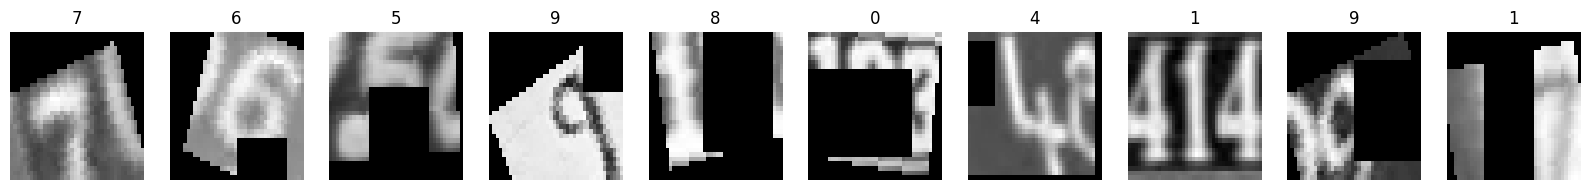

In [63]:
visualize_images(train_loader)

In [64]:
class CustomModel(nn.Module):
    def __init__(self,input_channels=1):
        super(CustomModel, self).__init__()

        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1,bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1,bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1,bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1,bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
        )
                
        self.fc = nn.Sequential(
            nn.Linear(4*5*512,256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128,10),
        )
        
        
    def forward(self, x):
        conv = self.conv(x)
   
        conv = conv.view(conv.size(0),-1)
        return self.fc(conv)

In [65]:
import gc
def clean_up():
    gc.collect()
    torch.cuda.empty_cache()

In [66]:
clean_up()

In [67]:
torch.autograd.set_detect_anomaly(mode=False)
torch.autograd.profiler.emit_nvtx(enabled=False)

torch.backends.cudnn.benchmark = True
torch.jit.enable_onednn_fusion(True)

In [68]:
import time

def train_single_batch(num_epochs):
    model = CustomModel().to(device)
    optimizer = optim.Adam(model.parameters(),lr=3e-4)
    loss_fn = nn.CrossEntropyLoss()
    
    images,labels = next(iter(train_loader))
    labels = labels.view(-1)

    for epoch in range(num_epochs):
        start = time.time()
        
        model.train()
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        outputs = model(images) # 64x10
        
        loss = loss_fn(outputs, labels)
        
            
        loss.backward()
        optimizer.step()
    
        
        end_train = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Train Time: {end_train-start:.4f}")


In [69]:
train_single_batch(60)

Epoch [1/60], Loss: 2.3159, Train Time: 2.3442
Epoch [2/60], Loss: 2.2835, Train Time: 0.0182
Epoch [3/60], Loss: 2.2609, Train Time: 0.0052
Epoch [4/60], Loss: 2.2618, Train Time: 0.0056
Epoch [5/60], Loss: 2.2567, Train Time: 0.0055
Epoch [6/60], Loss: 2.2251, Train Time: 0.0051
Epoch [7/60], Loss: 2.2296, Train Time: 0.0053
Epoch [8/60], Loss: 2.2132, Train Time: 0.0054
Epoch [9/60], Loss: 2.1866, Train Time: 0.0052
Epoch [10/60], Loss: 2.1759, Train Time: 0.0053
Epoch [11/60], Loss: 2.1787, Train Time: 0.0057
Epoch [12/60], Loss: 2.1722, Train Time: 0.0055
Epoch [13/60], Loss: 2.1453, Train Time: 0.0052
Epoch [14/60], Loss: 2.1205, Train Time: 0.0057
Epoch [15/60], Loss: 2.1164, Train Time: 0.0051
Epoch [16/60], Loss: 2.0743, Train Time: 0.0051
Epoch [17/60], Loss: 2.0614, Train Time: 0.0057
Epoch [18/60], Loss: 2.0327, Train Time: 0.0051
Epoch [19/60], Loss: 2.0069, Train Time: 0.0053
Epoch [20/60], Loss: 1.9712, Train Time: 0.0068
Epoch [21/60], Loss: 1.9524, Train Time: 0.0050
E

In [70]:
model = CustomModel().to(device)
loss_fn = nn.CrossEntropyLoss()

In [71]:
optimizer = optim.Adam(model.parameters(),lr=3e-4)

In [72]:
from torch.cuda.amp import autocast, GradScaler

def train(model, num_epochs,optimizer,loss_fn,train_loader,test_loader):
    scaler = GradScaler()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_train = 0.0
        total_train=0.0
        start = time.time()
        for images,labels in train_loader:

            model.train()

            images, labels = images.to(device,non_blocking=True), labels.to(device,non_blocking=True)
            labels = labels.view(-1)
            
            optimizer.zero_grad(set_to_none=True)
            
            with autocast(dtype=torch.float16):
                outputs = model(images)
                loss = loss_fn(outputs, labels)
        
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            
            epoch_loss+=loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train+=labels.size(0)
            correct_train += (predicted == labels).sum().item()
            

        end_train = time.time()
            
        model.eval()
        val_loss = 0.0
        correct_val = 0.0
        total_val = 0.0
        
        
        with torch.no_grad():
            for images,labels in test_loader:
                images, labels = images.to(device,non_blocking=True), labels.to(device,non_blocking=True)
                
                labels = labels.view(-1)
                
                with autocast(dtype=torch.float16):
                    outputs = model(images)
                    loss=loss_fn(outputs,labels)
                
                val_loss+=loss.item()
                
                predicted = torch.argmax(outputs.data, 1)
                total_val+=labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
            
        end_val = time.time()
        
        val_loss/=len(test_loader)
        correct_val /= total_val
        
        correct_train /= total_train
        epoch_loss/=len(train_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Train Acc: {correct_train:.4f}, Train Time: {end_train-start:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {correct_val:.4f}, Inference Time: {end_val-end_train:.4f}")

In [ ]:
train(model,10,optimizer,loss_fn,train_loader,test_loader)

In [ ]:
torch.save(model, "hybrid_model.pt")

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=1e-5)
train(model, 5,optimizer,loss_fn,train_loader,test_loader)

In [ ]:
torch.save(model, "hybrid_model2.pt")